In [ ]:
#@title Texto de título predeterminado
#instalando librerias 
%pip install geopandas
%pip install rasterio
%pip install pycrs

In [3]:
#importando librerias

import cv2
import geopandas as gpd
import numpy as np
import rasterio as rst
import matplotlib.pyplot as plt
from rasterio.plot import show
import os
import pycrs
from rasterio.mask import mask

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


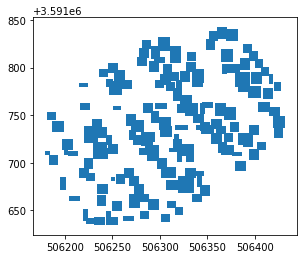

In [4]:
#importando shape con poligonos de deteccion
gdf = gpd.read_file('/content/drive/MyDrive/data 4 NB/open_cv test/shapes/detected areas.shp')
gdf.plot()

In [5]:
#muestra del geodataframe
gdf.sample(3)

,FID,LAYER,NAME,geometry
92,146,"Detected data (2.00 cm/pix, any color, trained...",None,"POLYGON ((506342.340 3591763.159, 506347.060 3..."
20,74,"Detected data (2.00 cm/pix, any color, trained...",None,"POLYGON ((506222.765 3591689.221, 506231.944 3..."
128,182,"Detected data (2.00 cm/pix, any color, trained...",None,"POLYGON ((506367.280 3591730.960, 506376.539 3..."


In [6]:
#obtenemos el raster
raster = rst.open('/content/drive/MyDrive/data 4 NB/open_cv test/rasters/odm_orthophoto/odm_orthophoto.tif') 


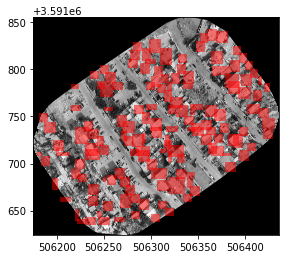

In [51]:
#visualizamos el raster junto con los poligonos
gdf.plot(alpha = 0.5, color = 'r')  #poligonos
show((raster, 1),cmap='gray')  #raster

In [9]:
#rectificamos que ambos tengan elmismo sistema de coordenadas
print(gdf.crs)
print(raster.crs)

epsg:32611
EPSG:32611


In [52]:
#obtenemos un solo polignono

bbox = gdf.loc[1,'geometry'].bounds
bbox

(506181.58622522047, 3591744.51927678, 506190.925890157, 3591753.6189503283)

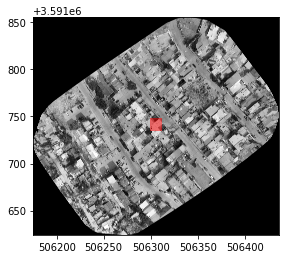

In [121]:
#visualizamos el poligono

s = 70

gdf.loc[[s],'geometry'].plot(alpha = 0.5, color = 'r')

show((raster, 1),cmap='gray')



In [122]:


def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [123]:

coords = getFeatures(gdf.loc[[s],'geometry'])
print(coords)

[{'type': 'Polygon', 'coordinates': [[[506299.0420114603, 3591747.879156245], [506312.2015393583, 3591747.879156245], [506312.20153935876, 3591734.079651306], [506299.04201146006, 3591734.0796513073], [506299.0420114603, 3591747.879156245]]]}]


In [124]:

out_img, out_transform = mask(dataset=raster, shapes=coords, crop=True)

In [125]:
out_meta = raster.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 13070, 'height': 11563, 'count': 4, 'crs': CRS.from_epsg(32611), 'transform': Affine(0.01999866525552078, 0.0, 506175.0464598688,
       0.0, -0.019999899778621096, 3591855.435297619)}


In [126]:


out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                         )

In [127]:
pycrs.parse.from_epsg_code(epsg_code).to_proj4()

'+proj=utm +datum=WGS84 +ellps=WGS84 +a=6378137.0 +rf=298.257223563 +pm=0  +units=m +axis=enu +no_defs'

In [128]:


out_tif = os.path.join('rasters/odm_orthophoto/', "Helsinki_Masked.tif")

In [129]:
len(out_img)

4

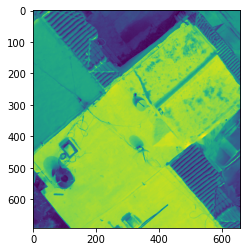

In [130]:

plt.imshow(out_img[1])

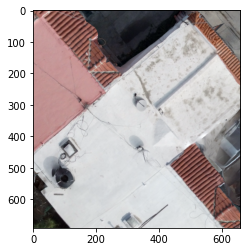

In [131]:
img_combined = cv2.merge((out_img[0],out_img[1],out_img[2]))

plt.imshow(img_combined)

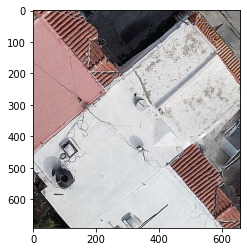

In [132]:
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
import random as rng


imgLaplacian = cv2.filter2D(img_combined, cv2.CV_32F, kernel)
sharp = np.float32(img_combined)
imgResult = sharp - imgLaplacian
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)

plt.imshow(imgResult)


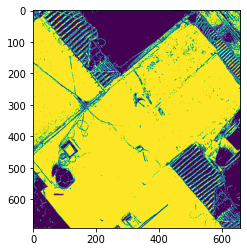

In [133]:
bw = cv2.cvtColor(imgResult, cv2.COLOR_BGR2GRAY)
_, bw = cv2.threshold(bw, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(bw)


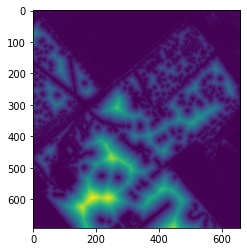

In [134]:
dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
plt.imshow(dist)

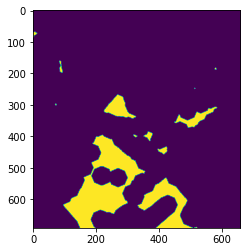

In [135]:
_, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv2.dilate(dist, kernel1)
plt.imshow(dist)

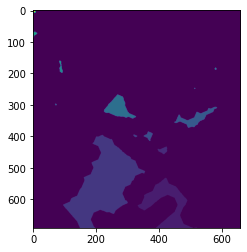

In [136]:
dist_8u = dist.astype('uint8')
# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv2.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')
plt.imshow(markers_8u)

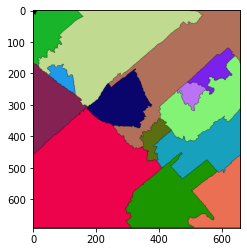

In [137]:


cv2.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
#cv2.imshow('Markers_v2', mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
# Visualize the final image
plt.imshow(dst)


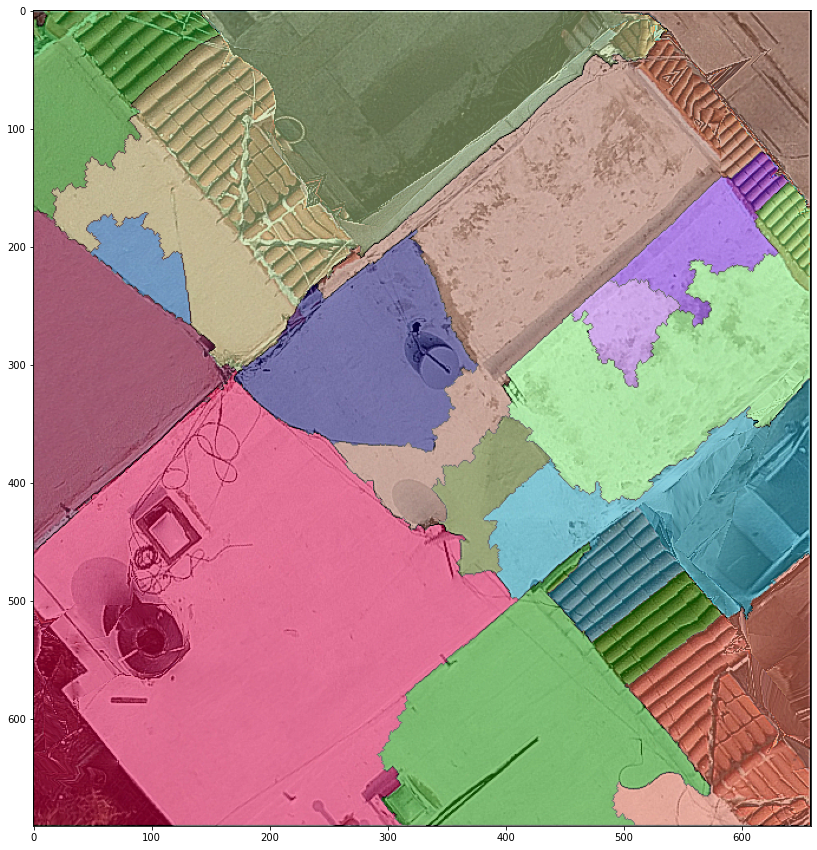

In [141]:
plt.figure(figsize=(15, 15))
plt.imshow(imgResult)
plt.imshow(dst, alpha = 0.5)


